In [1]:
import numpy as np
import matplotlib.pyplot as plt
from random import seed
from random import random, uniform

In [2]:
def generate_linear(n=100):
    pts = np.random.uniform(0, 1, (n, 2))
    inputs = []
    labels = []
    for pt in pts:
        inputs.append([pt[0], pt[1]])
        distance = (pt[0] - pt[1]) / 1.414
        if pt[0] > pt[1]:
            labels.append(0)
        else:
            labels.append(1)
    return np.array(inputs), np.array(labels).reshape(n, 1)

In [3]:
def generate_XOR_easy():
    inputs = []
    labels = []
    
    for i in range(11):
        inputs.append([0.1*i, 0.1*i])
        labels.append(0)
        
        if 0.1*i == 0.5:
            continue
        
        inputs.append([0.1*i, 1-0.1*i])
        labels.append(1)
        
    return np.array(inputs), np.array(labels).reshape(21, 1)

In [4]:
def show_result(x, y, pred_y):
    plt.subplot(1, 2, 1)
    plt.title("Ground Truth", fontsize = 18)
    for i in range(x.shape[0]):
        if y[i] == 0:
            plt.plot(x[i][0], x[i][1], 'ro')
        else:
            plt.plot(x[i][0], x[i][1], 'bo')
    plt.subplot(1, 2, 2)
    plt.title('Predict result', fontsize = 18)
    for i in range(x.shape[0]):
        if abs(pred_y[i]) >=0.9:
            plt.plot(x[i][0], x[i][1], 'bo')
            print("print Blue", pred_y[i])
        else:
            plt.plot(x[i][0], x[i][1], 'ro')
            print("print Red", pred_y[i])
            
    plt.show()

In [5]:
def learningCurve(n_epoch, loss):
    plt.title("Learning Curve", fontsize = 18)
    plt.plot([x for x in range(1,n_epoch+1)], loss,color='blue', label="learning curve")
    plt.legend(loc = 'upper right')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

In [6]:
# make a new Neural Network
def establishNN(n_inputs, n_hidden1, n_hidden2, n_output):
    network = list()
    hidden1 = [{"weight":[uniform(-1,1)   for __ in range(n_inputs+1)]}for _ in range(n_hidden1)] #weight[-1] is for Bias
    network.append(hidden1)
    hidden2 = [{"weight":[uniform(-1,1)    for __ in range(n_hidden1+1)]}for _ in range(n_hidden2)]
    network.append(hidden2)
    output = [{"weight":[uniform(-1,1)   for __ in range(n_hidden2+1)]}for _ in range(n_output)]
    network.append(output)
    print("----Network Description----")
    print(f"total {len(network)} layers")
    print("two hidden layer")
    print("one output layer")
    for index, layer in enumerate(network):
        print(f"-Layer {index+1}-")
        print(f"{len(layer)} neurons")
        for neu_index, neuron in enumerate(layer):
            print(f"neuron{neu_index}:")
            print(f"weight:{neuron['weight'][:-1]}")
            print(f"bias:{neuron['weight'][-1]}")
    print("---------------------------")
    return network

In [7]:
#Caculate "net" value
#weights(List): the weight between inputs and neurons. Notice: weights[-1] is the bias. 
#inputs(List): X_train or the outputs of previous layer
def activateProcess(weights, inputs):
    bias = weights[-1]
    value = -bias
    for i in range(len(weights)-1):
        value += weights[i]*inputs[i]
#         print("activate", inputs[i])
    return value

In [8]:
def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x))

In [9]:
def foward(networks, rowData):
    inputs = rowData #get input data(by one data) Ex. x[0]~x[n]
#     print("forward_input",inputs)
    for layer in networks:
        new_inputs = list()
        for neuron in layer:
            output = activateProcess(neuron["weight"], inputs)
            output_sigmoid = sigmoid(output)
            neuron["output"] = output_sigmoid
            new_inputs.append(output_sigmoid)
        inputs = new_inputs
    return inputs

In [10]:
def derivate_sigmoid(x):
    return x * (1.0 - x)

In [11]:
#groundTruth: y(List), y[0]~y[n]
def backwardPropagation(network, groundTruth):
    for i in reversed(range(len(network))):
        if i == (len(network)-1):
            #It is a  output layer!
            for index, neuron in enumerate(network[i]):
                diff = groundTruth[index]-neuron['output']
                neuron['delta'] = diff  #The Derivative of MSE -> -(T-Y)
        else:
            #It is not a ouput layer!
            for index, neuron in enumerate(network[i]):
                error = 0
                for nextNeuron in network[i+1]:
                    error += nextNeuron['weight'][index] * nextNeuron['delta']
                neuron['delta'] = error
                      
        for neuron in network[i]:
            neuron['delta'] = neuron['delta'] * derivate_sigmoid(neuron['output'])
                

In [12]:
#initInputs: Original input(X_train)
def updateWeight(network, initInputs, l_rate):
    inputs = initInputs
    tempInput = list()
    for nowIndex, layer in enumerate(network):
        if nowIndex != 0:
            # Not First Hidden layer
            inputs = tempInput.copy()
            tempInput.clear()
        for neuron in layer:
            for index, inputItem in enumerate(inputs):
                neuron['weight'][index] +=  l_rate * neuron['delta'] * inputItem #For weight
            neuron['weight'][-1] += -(l_rate) * neuron['delta'] # For Bias
            tempInput.append(neuron['output'])
                

In [13]:
def trainNetwork(network, X_train, Y_train, l_rate, n_epoch, n_outputs, havelearningCurve=True):
    errorList = list()
    for epoch in range(n_epoch):
        sum_error = 0
        for index, row in enumerate(X_train):
            #row: [0.1, 0.2]
            Y_predict = foward(network, row) #n_outputs dimension
            sum_error += sum([(Y_train[index][i]-Y_predict[i])**2 for i in range(n_outputs)]) 
            backwardPropagation(network, Y_train[index])
            updateWeight(network, row, l_rate)
        error = sum_error/len(X_train)
        errorList.append(round(error, 3))
        print('==epoch=%d, lrate=%.3f, error=%.3f==' % (epoch, l_rate, error))
    if havelearningCurve:
        learningCurve(n_epoch, errorList)

In [14]:
def predictModel(network, X_train):
    result = list()
    for index, row in enumerate(X_train):
        print(f"Predict:{index}, {row}")
        Y_predict = foward(network, row)
        result.append(Y_predict[0])
    return result

----Network Description----
total 3 layers
two hidden layer
one output layer
-Layer 1-
2 neurons
neuron0:
weight:[-0.7312715117751976, 0.6948674738744653]
bias:0.5275492379532281
neuron1:
weight:[-0.4898619485211566, -0.009129825816118098]
bias:-0.10101787042252375
-Layer 2-
2 neurons
neuron0:
weight:[0.3031859454455259, 0.5774467022710263]
bias:-0.8122808264515302
neuron1:
weight:[-0.9433050469559874, 0.6715302078397394]
bias:-0.13446586418989326
-Layer 3-
1 neurons
neuron0:
weight:[0.524560164915884, -0.9957878932977786]
bias:-0.10922561189039715
---------------------------
==epoch=0, lrate=4.000, error=0.381==
==epoch=1, lrate=4.000, error=0.360==
==epoch=2, lrate=4.000, error=0.344==
==epoch=3, lrate=4.000, error=0.335==
==epoch=4, lrate=4.000, error=0.331==
==epoch=5, lrate=4.000, error=0.328==
==epoch=6, lrate=4.000, error=0.326==
==epoch=7, lrate=4.000, error=0.325==
==epoch=8, lrate=4.000, error=0.325==
==epoch=9, lrate=4.000, error=0.324==
==epoch=10, lrate=4.000, error=0.324=

==epoch=236, lrate=4.000, error=0.218==
==epoch=237, lrate=4.000, error=0.218==
==epoch=238, lrate=4.000, error=0.218==
==epoch=239, lrate=4.000, error=0.218==
==epoch=240, lrate=4.000, error=0.217==
==epoch=241, lrate=4.000, error=0.217==
==epoch=242, lrate=4.000, error=0.217==
==epoch=243, lrate=4.000, error=0.217==
==epoch=244, lrate=4.000, error=0.217==
==epoch=245, lrate=4.000, error=0.217==
==epoch=246, lrate=4.000, error=0.216==
==epoch=247, lrate=4.000, error=0.216==
==epoch=248, lrate=4.000, error=0.216==
==epoch=249, lrate=4.000, error=0.216==
==epoch=250, lrate=4.000, error=0.216==
==epoch=251, lrate=4.000, error=0.215==
==epoch=252, lrate=4.000, error=0.215==
==epoch=253, lrate=4.000, error=0.215==
==epoch=254, lrate=4.000, error=0.215==
==epoch=255, lrate=4.000, error=0.215==
==epoch=256, lrate=4.000, error=0.214==
==epoch=257, lrate=4.000, error=0.214==
==epoch=258, lrate=4.000, error=0.214==
==epoch=259, lrate=4.000, error=0.214==
==epoch=260, lrate=4.000, error=0.213==


==epoch=497, lrate=4.000, error=0.001==
==epoch=498, lrate=4.000, error=0.001==
==epoch=499, lrate=4.000, error=0.001==
==epoch=500, lrate=4.000, error=0.001==
==epoch=501, lrate=4.000, error=0.001==
==epoch=502, lrate=4.000, error=0.001==
==epoch=503, lrate=4.000, error=0.001==
==epoch=504, lrate=4.000, error=0.001==
==epoch=505, lrate=4.000, error=0.001==
==epoch=506, lrate=4.000, error=0.001==
==epoch=507, lrate=4.000, error=0.001==
==epoch=508, lrate=4.000, error=0.001==
==epoch=509, lrate=4.000, error=0.001==
==epoch=510, lrate=4.000, error=0.001==
==epoch=511, lrate=4.000, error=0.001==
==epoch=512, lrate=4.000, error=0.001==
==epoch=513, lrate=4.000, error=0.001==
==epoch=514, lrate=4.000, error=0.001==
==epoch=515, lrate=4.000, error=0.001==
==epoch=516, lrate=4.000, error=0.001==
==epoch=517, lrate=4.000, error=0.001==
==epoch=518, lrate=4.000, error=0.001==
==epoch=519, lrate=4.000, error=0.001==
==epoch=520, lrate=4.000, error=0.001==
==epoch=521, lrate=4.000, error=0.001==


==epoch=766, lrate=4.000, error=0.000==
==epoch=767, lrate=4.000, error=0.000==
==epoch=768, lrate=4.000, error=0.000==
==epoch=769, lrate=4.000, error=0.000==
==epoch=770, lrate=4.000, error=0.000==
==epoch=771, lrate=4.000, error=0.000==
==epoch=772, lrate=4.000, error=0.000==
==epoch=773, lrate=4.000, error=0.000==
==epoch=774, lrate=4.000, error=0.000==
==epoch=775, lrate=4.000, error=0.000==
==epoch=776, lrate=4.000, error=0.000==
==epoch=777, lrate=4.000, error=0.000==
==epoch=778, lrate=4.000, error=0.000==
==epoch=779, lrate=4.000, error=0.000==
==epoch=780, lrate=4.000, error=0.000==
==epoch=781, lrate=4.000, error=0.000==
==epoch=782, lrate=4.000, error=0.000==
==epoch=783, lrate=4.000, error=0.000==
==epoch=784, lrate=4.000, error=0.000==
==epoch=785, lrate=4.000, error=0.000==
==epoch=786, lrate=4.000, error=0.000==
==epoch=787, lrate=4.000, error=0.000==
==epoch=788, lrate=4.000, error=0.000==
==epoch=789, lrate=4.000, error=0.000==
==epoch=790, lrate=4.000, error=0.000==


==epoch=1032, lrate=4.000, error=0.000==
==epoch=1033, lrate=4.000, error=0.000==
==epoch=1034, lrate=4.000, error=0.000==
==epoch=1035, lrate=4.000, error=0.000==
==epoch=1036, lrate=4.000, error=0.000==
==epoch=1037, lrate=4.000, error=0.000==
==epoch=1038, lrate=4.000, error=0.000==
==epoch=1039, lrate=4.000, error=0.000==
==epoch=1040, lrate=4.000, error=0.000==
==epoch=1041, lrate=4.000, error=0.000==
==epoch=1042, lrate=4.000, error=0.000==
==epoch=1043, lrate=4.000, error=0.000==
==epoch=1044, lrate=4.000, error=0.000==
==epoch=1045, lrate=4.000, error=0.000==
==epoch=1046, lrate=4.000, error=0.000==
==epoch=1047, lrate=4.000, error=0.000==
==epoch=1048, lrate=4.000, error=0.000==
==epoch=1049, lrate=4.000, error=0.000==
==epoch=1050, lrate=4.000, error=0.000==
==epoch=1051, lrate=4.000, error=0.000==
==epoch=1052, lrate=4.000, error=0.000==
==epoch=1053, lrate=4.000, error=0.000==
==epoch=1054, lrate=4.000, error=0.000==
==epoch=1055, lrate=4.000, error=0.000==
==epoch=1056, lr

==epoch=1241, lrate=4.000, error=0.000==
==epoch=1242, lrate=4.000, error=0.000==
==epoch=1243, lrate=4.000, error=0.000==
==epoch=1244, lrate=4.000, error=0.000==
==epoch=1245, lrate=4.000, error=0.000==
==epoch=1246, lrate=4.000, error=0.000==
==epoch=1247, lrate=4.000, error=0.000==
==epoch=1248, lrate=4.000, error=0.000==
==epoch=1249, lrate=4.000, error=0.000==
==epoch=1250, lrate=4.000, error=0.000==
==epoch=1251, lrate=4.000, error=0.000==
==epoch=1252, lrate=4.000, error=0.000==
==epoch=1253, lrate=4.000, error=0.000==
==epoch=1254, lrate=4.000, error=0.000==
==epoch=1255, lrate=4.000, error=0.000==
==epoch=1256, lrate=4.000, error=0.000==
==epoch=1257, lrate=4.000, error=0.000==
==epoch=1258, lrate=4.000, error=0.000==
==epoch=1259, lrate=4.000, error=0.000==
==epoch=1260, lrate=4.000, error=0.000==
==epoch=1261, lrate=4.000, error=0.000==
==epoch=1262, lrate=4.000, error=0.000==
==epoch=1263, lrate=4.000, error=0.000==
==epoch=1264, lrate=4.000, error=0.000==
==epoch=1265, lr

==epoch=1474, lrate=4.000, error=0.000==
==epoch=1475, lrate=4.000, error=0.000==
==epoch=1476, lrate=4.000, error=0.000==
==epoch=1477, lrate=4.000, error=0.000==
==epoch=1478, lrate=4.000, error=0.000==
==epoch=1479, lrate=4.000, error=0.000==
==epoch=1480, lrate=4.000, error=0.000==
==epoch=1481, lrate=4.000, error=0.000==
==epoch=1482, lrate=4.000, error=0.000==
==epoch=1483, lrate=4.000, error=0.000==
==epoch=1484, lrate=4.000, error=0.000==
==epoch=1485, lrate=4.000, error=0.000==
==epoch=1486, lrate=4.000, error=0.000==
==epoch=1487, lrate=4.000, error=0.000==
==epoch=1488, lrate=4.000, error=0.000==
==epoch=1489, lrate=4.000, error=0.000==
==epoch=1490, lrate=4.000, error=0.000==
==epoch=1491, lrate=4.000, error=0.000==
==epoch=1492, lrate=4.000, error=0.000==
==epoch=1493, lrate=4.000, error=0.000==
==epoch=1494, lrate=4.000, error=0.000==
==epoch=1495, lrate=4.000, error=0.000==
==epoch=1496, lrate=4.000, error=0.000==
==epoch=1497, lrate=4.000, error=0.000==
==epoch=1498, lr

==epoch=1699, lrate=4.000, error=0.000==
==epoch=1700, lrate=4.000, error=0.000==
==epoch=1701, lrate=4.000, error=0.000==
==epoch=1702, lrate=4.000, error=0.000==
==epoch=1703, lrate=4.000, error=0.000==
==epoch=1704, lrate=4.000, error=0.000==
==epoch=1705, lrate=4.000, error=0.000==
==epoch=1706, lrate=4.000, error=0.000==
==epoch=1707, lrate=4.000, error=0.000==
==epoch=1708, lrate=4.000, error=0.000==
==epoch=1709, lrate=4.000, error=0.000==
==epoch=1710, lrate=4.000, error=0.000==
==epoch=1711, lrate=4.000, error=0.000==
==epoch=1712, lrate=4.000, error=0.000==
==epoch=1713, lrate=4.000, error=0.000==
==epoch=1714, lrate=4.000, error=0.000==
==epoch=1715, lrate=4.000, error=0.000==
==epoch=1716, lrate=4.000, error=0.000==
==epoch=1717, lrate=4.000, error=0.000==
==epoch=1718, lrate=4.000, error=0.000==
==epoch=1719, lrate=4.000, error=0.000==
==epoch=1720, lrate=4.000, error=0.000==
==epoch=1721, lrate=4.000, error=0.000==
==epoch=1722, lrate=4.000, error=0.000==
==epoch=1723, lr

==epoch=1931, lrate=4.000, error=0.000==
==epoch=1932, lrate=4.000, error=0.000==
==epoch=1933, lrate=4.000, error=0.000==
==epoch=1934, lrate=4.000, error=0.000==
==epoch=1935, lrate=4.000, error=0.000==
==epoch=1936, lrate=4.000, error=0.000==
==epoch=1937, lrate=4.000, error=0.000==
==epoch=1938, lrate=4.000, error=0.000==
==epoch=1939, lrate=4.000, error=0.000==
==epoch=1940, lrate=4.000, error=0.000==
==epoch=1941, lrate=4.000, error=0.000==
==epoch=1942, lrate=4.000, error=0.000==
==epoch=1943, lrate=4.000, error=0.000==
==epoch=1944, lrate=4.000, error=0.000==
==epoch=1945, lrate=4.000, error=0.000==
==epoch=1946, lrate=4.000, error=0.000==
==epoch=1947, lrate=4.000, error=0.000==
==epoch=1948, lrate=4.000, error=0.000==
==epoch=1949, lrate=4.000, error=0.000==
==epoch=1950, lrate=4.000, error=0.000==
==epoch=1951, lrate=4.000, error=0.000==
==epoch=1952, lrate=4.000, error=0.000==
==epoch=1953, lrate=4.000, error=0.000==
==epoch=1954, lrate=4.000, error=0.000==
==epoch=1955, lr

==epoch=2159, lrate=4.000, error=0.000==
==epoch=2160, lrate=4.000, error=0.000==
==epoch=2161, lrate=4.000, error=0.000==
==epoch=2162, lrate=4.000, error=0.000==
==epoch=2163, lrate=4.000, error=0.000==
==epoch=2164, lrate=4.000, error=0.000==
==epoch=2165, lrate=4.000, error=0.000==
==epoch=2166, lrate=4.000, error=0.000==
==epoch=2167, lrate=4.000, error=0.000==
==epoch=2168, lrate=4.000, error=0.000==
==epoch=2169, lrate=4.000, error=0.000==
==epoch=2170, lrate=4.000, error=0.000==
==epoch=2171, lrate=4.000, error=0.000==
==epoch=2172, lrate=4.000, error=0.000==
==epoch=2173, lrate=4.000, error=0.000==
==epoch=2174, lrate=4.000, error=0.000==
==epoch=2175, lrate=4.000, error=0.000==
==epoch=2176, lrate=4.000, error=0.000==
==epoch=2177, lrate=4.000, error=0.000==
==epoch=2178, lrate=4.000, error=0.000==
==epoch=2179, lrate=4.000, error=0.000==
==epoch=2180, lrate=4.000, error=0.000==
==epoch=2181, lrate=4.000, error=0.000==
==epoch=2182, lrate=4.000, error=0.000==
==epoch=2183, lr

==epoch=2389, lrate=4.000, error=0.000==
==epoch=2390, lrate=4.000, error=0.000==
==epoch=2391, lrate=4.000, error=0.000==
==epoch=2392, lrate=4.000, error=0.000==
==epoch=2393, lrate=4.000, error=0.000==
==epoch=2394, lrate=4.000, error=0.000==
==epoch=2395, lrate=4.000, error=0.000==
==epoch=2396, lrate=4.000, error=0.000==
==epoch=2397, lrate=4.000, error=0.000==
==epoch=2398, lrate=4.000, error=0.000==
==epoch=2399, lrate=4.000, error=0.000==
==epoch=2400, lrate=4.000, error=0.000==
==epoch=2401, lrate=4.000, error=0.000==
==epoch=2402, lrate=4.000, error=0.000==
==epoch=2403, lrate=4.000, error=0.000==
==epoch=2404, lrate=4.000, error=0.000==
==epoch=2405, lrate=4.000, error=0.000==
==epoch=2406, lrate=4.000, error=0.000==
==epoch=2407, lrate=4.000, error=0.000==
==epoch=2408, lrate=4.000, error=0.000==
==epoch=2409, lrate=4.000, error=0.000==
==epoch=2410, lrate=4.000, error=0.000==
==epoch=2411, lrate=4.000, error=0.000==
==epoch=2412, lrate=4.000, error=0.000==
==epoch=2413, lr

==epoch=2618, lrate=4.000, error=0.000==
==epoch=2619, lrate=4.000, error=0.000==
==epoch=2620, lrate=4.000, error=0.000==
==epoch=2621, lrate=4.000, error=0.000==
==epoch=2622, lrate=4.000, error=0.000==
==epoch=2623, lrate=4.000, error=0.000==
==epoch=2624, lrate=4.000, error=0.000==
==epoch=2625, lrate=4.000, error=0.000==
==epoch=2626, lrate=4.000, error=0.000==
==epoch=2627, lrate=4.000, error=0.000==
==epoch=2628, lrate=4.000, error=0.000==
==epoch=2629, lrate=4.000, error=0.000==
==epoch=2630, lrate=4.000, error=0.000==
==epoch=2631, lrate=4.000, error=0.000==
==epoch=2632, lrate=4.000, error=0.000==
==epoch=2633, lrate=4.000, error=0.000==
==epoch=2634, lrate=4.000, error=0.000==
==epoch=2635, lrate=4.000, error=0.000==
==epoch=2636, lrate=4.000, error=0.000==
==epoch=2637, lrate=4.000, error=0.000==
==epoch=2638, lrate=4.000, error=0.000==
==epoch=2639, lrate=4.000, error=0.000==
==epoch=2640, lrate=4.000, error=0.000==
==epoch=2641, lrate=4.000, error=0.000==
==epoch=2642, lr

==epoch=2855, lrate=4.000, error=0.000==
==epoch=2856, lrate=4.000, error=0.000==
==epoch=2857, lrate=4.000, error=0.000==
==epoch=2858, lrate=4.000, error=0.000==
==epoch=2859, lrate=4.000, error=0.000==
==epoch=2860, lrate=4.000, error=0.000==
==epoch=2861, lrate=4.000, error=0.000==
==epoch=2862, lrate=4.000, error=0.000==
==epoch=2863, lrate=4.000, error=0.000==
==epoch=2864, lrate=4.000, error=0.000==
==epoch=2865, lrate=4.000, error=0.000==
==epoch=2866, lrate=4.000, error=0.000==
==epoch=2867, lrate=4.000, error=0.000==
==epoch=2868, lrate=4.000, error=0.000==
==epoch=2869, lrate=4.000, error=0.000==
==epoch=2870, lrate=4.000, error=0.000==
==epoch=2871, lrate=4.000, error=0.000==
==epoch=2872, lrate=4.000, error=0.000==
==epoch=2873, lrate=4.000, error=0.000==
==epoch=2874, lrate=4.000, error=0.000==
==epoch=2875, lrate=4.000, error=0.000==
==epoch=2876, lrate=4.000, error=0.000==
==epoch=2877, lrate=4.000, error=0.000==
==epoch=2878, lrate=4.000, error=0.000==
==epoch=2879, lr

==epoch=3125, lrate=4.000, error=0.000==
==epoch=3126, lrate=4.000, error=0.000==
==epoch=3127, lrate=4.000, error=0.000==
==epoch=3128, lrate=4.000, error=0.000==
==epoch=3129, lrate=4.000, error=0.000==
==epoch=3130, lrate=4.000, error=0.000==
==epoch=3131, lrate=4.000, error=0.000==
==epoch=3132, lrate=4.000, error=0.000==
==epoch=3133, lrate=4.000, error=0.000==
==epoch=3134, lrate=4.000, error=0.000==
==epoch=3135, lrate=4.000, error=0.000==
==epoch=3136, lrate=4.000, error=0.000==
==epoch=3137, lrate=4.000, error=0.000==
==epoch=3138, lrate=4.000, error=0.000==
==epoch=3139, lrate=4.000, error=0.000==
==epoch=3140, lrate=4.000, error=0.000==
==epoch=3141, lrate=4.000, error=0.000==
==epoch=3142, lrate=4.000, error=0.000==
==epoch=3143, lrate=4.000, error=0.000==
==epoch=3144, lrate=4.000, error=0.000==
==epoch=3145, lrate=4.000, error=0.000==
==epoch=3146, lrate=4.000, error=0.000==
==epoch=3147, lrate=4.000, error=0.000==
==epoch=3148, lrate=4.000, error=0.000==
==epoch=3149, lr

==epoch=3377, lrate=4.000, error=0.000==
==epoch=3378, lrate=4.000, error=0.000==
==epoch=3379, lrate=4.000, error=0.000==
==epoch=3380, lrate=4.000, error=0.000==
==epoch=3381, lrate=4.000, error=0.000==
==epoch=3382, lrate=4.000, error=0.000==
==epoch=3383, lrate=4.000, error=0.000==
==epoch=3384, lrate=4.000, error=0.000==
==epoch=3385, lrate=4.000, error=0.000==
==epoch=3386, lrate=4.000, error=0.000==
==epoch=3387, lrate=4.000, error=0.000==
==epoch=3388, lrate=4.000, error=0.000==
==epoch=3389, lrate=4.000, error=0.000==
==epoch=3390, lrate=4.000, error=0.000==
==epoch=3391, lrate=4.000, error=0.000==
==epoch=3392, lrate=4.000, error=0.000==
==epoch=3393, lrate=4.000, error=0.000==
==epoch=3394, lrate=4.000, error=0.000==
==epoch=3395, lrate=4.000, error=0.000==
==epoch=3396, lrate=4.000, error=0.000==
==epoch=3397, lrate=4.000, error=0.000==
==epoch=3398, lrate=4.000, error=0.000==
==epoch=3399, lrate=4.000, error=0.000==
==epoch=3400, lrate=4.000, error=0.000==
==epoch=3401, lr

==epoch=3623, lrate=4.000, error=0.000==
==epoch=3624, lrate=4.000, error=0.000==
==epoch=3625, lrate=4.000, error=0.000==
==epoch=3626, lrate=4.000, error=0.000==
==epoch=3627, lrate=4.000, error=0.000==
==epoch=3628, lrate=4.000, error=0.000==
==epoch=3629, lrate=4.000, error=0.000==
==epoch=3630, lrate=4.000, error=0.000==
==epoch=3631, lrate=4.000, error=0.000==
==epoch=3632, lrate=4.000, error=0.000==
==epoch=3633, lrate=4.000, error=0.000==
==epoch=3634, lrate=4.000, error=0.000==
==epoch=3635, lrate=4.000, error=0.000==
==epoch=3636, lrate=4.000, error=0.000==
==epoch=3637, lrate=4.000, error=0.000==
==epoch=3638, lrate=4.000, error=0.000==
==epoch=3639, lrate=4.000, error=0.000==
==epoch=3640, lrate=4.000, error=0.000==
==epoch=3641, lrate=4.000, error=0.000==
==epoch=3642, lrate=4.000, error=0.000==
==epoch=3643, lrate=4.000, error=0.000==
==epoch=3644, lrate=4.000, error=0.000==
==epoch=3645, lrate=4.000, error=0.000==
==epoch=3646, lrate=4.000, error=0.000==
==epoch=3647, lr

==epoch=3869, lrate=4.000, error=0.000==
==epoch=3870, lrate=4.000, error=0.000==
==epoch=3871, lrate=4.000, error=0.000==
==epoch=3872, lrate=4.000, error=0.000==
==epoch=3873, lrate=4.000, error=0.000==
==epoch=3874, lrate=4.000, error=0.000==
==epoch=3875, lrate=4.000, error=0.000==
==epoch=3876, lrate=4.000, error=0.000==
==epoch=3877, lrate=4.000, error=0.000==
==epoch=3878, lrate=4.000, error=0.000==
==epoch=3879, lrate=4.000, error=0.000==
==epoch=3880, lrate=4.000, error=0.000==
==epoch=3881, lrate=4.000, error=0.000==
==epoch=3882, lrate=4.000, error=0.000==
==epoch=3883, lrate=4.000, error=0.000==
==epoch=3884, lrate=4.000, error=0.000==
==epoch=3885, lrate=4.000, error=0.000==
==epoch=3886, lrate=4.000, error=0.000==
==epoch=3887, lrate=4.000, error=0.000==
==epoch=3888, lrate=4.000, error=0.000==
==epoch=3889, lrate=4.000, error=0.000==
==epoch=3890, lrate=4.000, error=0.000==
==epoch=3891, lrate=4.000, error=0.000==
==epoch=3892, lrate=4.000, error=0.000==
==epoch=3893, lr

==epoch=4104, lrate=4.000, error=0.000==
==epoch=4105, lrate=4.000, error=0.000==
==epoch=4106, lrate=4.000, error=0.000==
==epoch=4107, lrate=4.000, error=0.000==
==epoch=4108, lrate=4.000, error=0.000==
==epoch=4109, lrate=4.000, error=0.000==
==epoch=4110, lrate=4.000, error=0.000==
==epoch=4111, lrate=4.000, error=0.000==
==epoch=4112, lrate=4.000, error=0.000==
==epoch=4113, lrate=4.000, error=0.000==
==epoch=4114, lrate=4.000, error=0.000==
==epoch=4115, lrate=4.000, error=0.000==
==epoch=4116, lrate=4.000, error=0.000==
==epoch=4117, lrate=4.000, error=0.000==
==epoch=4118, lrate=4.000, error=0.000==
==epoch=4119, lrate=4.000, error=0.000==
==epoch=4120, lrate=4.000, error=0.000==
==epoch=4121, lrate=4.000, error=0.000==
==epoch=4122, lrate=4.000, error=0.000==
==epoch=4123, lrate=4.000, error=0.000==
==epoch=4124, lrate=4.000, error=0.000==
==epoch=4125, lrate=4.000, error=0.000==
==epoch=4126, lrate=4.000, error=0.000==
==epoch=4127, lrate=4.000, error=0.000==
==epoch=4128, lr

==epoch=4331, lrate=4.000, error=0.000==
==epoch=4332, lrate=4.000, error=0.000==
==epoch=4333, lrate=4.000, error=0.000==
==epoch=4334, lrate=4.000, error=0.000==
==epoch=4335, lrate=4.000, error=0.000==
==epoch=4336, lrate=4.000, error=0.000==
==epoch=4337, lrate=4.000, error=0.000==
==epoch=4338, lrate=4.000, error=0.000==
==epoch=4339, lrate=4.000, error=0.000==
==epoch=4340, lrate=4.000, error=0.000==
==epoch=4341, lrate=4.000, error=0.000==
==epoch=4342, lrate=4.000, error=0.000==
==epoch=4343, lrate=4.000, error=0.000==
==epoch=4344, lrate=4.000, error=0.000==
==epoch=4345, lrate=4.000, error=0.000==
==epoch=4346, lrate=4.000, error=0.000==
==epoch=4347, lrate=4.000, error=0.000==
==epoch=4348, lrate=4.000, error=0.000==
==epoch=4349, lrate=4.000, error=0.000==
==epoch=4350, lrate=4.000, error=0.000==
==epoch=4351, lrate=4.000, error=0.000==
==epoch=4352, lrate=4.000, error=0.000==
==epoch=4353, lrate=4.000, error=0.000==
==epoch=4354, lrate=4.000, error=0.000==
==epoch=4355, lr

==epoch=4549, lrate=4.000, error=0.000==
==epoch=4550, lrate=4.000, error=0.000==
==epoch=4551, lrate=4.000, error=0.000==
==epoch=4552, lrate=4.000, error=0.000==
==epoch=4553, lrate=4.000, error=0.000==
==epoch=4554, lrate=4.000, error=0.000==
==epoch=4555, lrate=4.000, error=0.000==
==epoch=4556, lrate=4.000, error=0.000==
==epoch=4557, lrate=4.000, error=0.000==
==epoch=4558, lrate=4.000, error=0.000==
==epoch=4559, lrate=4.000, error=0.000==
==epoch=4560, lrate=4.000, error=0.000==
==epoch=4561, lrate=4.000, error=0.000==
==epoch=4562, lrate=4.000, error=0.000==
==epoch=4563, lrate=4.000, error=0.000==
==epoch=4564, lrate=4.000, error=0.000==
==epoch=4565, lrate=4.000, error=0.000==
==epoch=4566, lrate=4.000, error=0.000==
==epoch=4567, lrate=4.000, error=0.000==
==epoch=4568, lrate=4.000, error=0.000==
==epoch=4569, lrate=4.000, error=0.000==
==epoch=4570, lrate=4.000, error=0.000==
==epoch=4571, lrate=4.000, error=0.000==
==epoch=4572, lrate=4.000, error=0.000==
==epoch=4573, lr

==epoch=4776, lrate=4.000, error=0.000==
==epoch=4777, lrate=4.000, error=0.000==
==epoch=4778, lrate=4.000, error=0.000==
==epoch=4779, lrate=4.000, error=0.000==
==epoch=4780, lrate=4.000, error=0.000==
==epoch=4781, lrate=4.000, error=0.000==
==epoch=4782, lrate=4.000, error=0.000==
==epoch=4783, lrate=4.000, error=0.000==
==epoch=4784, lrate=4.000, error=0.000==
==epoch=4785, lrate=4.000, error=0.000==
==epoch=4786, lrate=4.000, error=0.000==
==epoch=4787, lrate=4.000, error=0.000==
==epoch=4788, lrate=4.000, error=0.000==
==epoch=4789, lrate=4.000, error=0.000==
==epoch=4790, lrate=4.000, error=0.000==
==epoch=4791, lrate=4.000, error=0.000==
==epoch=4792, lrate=4.000, error=0.000==
==epoch=4793, lrate=4.000, error=0.000==
==epoch=4794, lrate=4.000, error=0.000==
==epoch=4795, lrate=4.000, error=0.000==
==epoch=4796, lrate=4.000, error=0.000==
==epoch=4797, lrate=4.000, error=0.000==
==epoch=4798, lrate=4.000, error=0.000==
==epoch=4799, lrate=4.000, error=0.000==
==epoch=4800, lr

==epoch=5000, lrate=4.000, error=0.000==
==epoch=5001, lrate=4.000, error=0.000==
==epoch=5002, lrate=4.000, error=0.000==
==epoch=5003, lrate=4.000, error=0.000==
==epoch=5004, lrate=4.000, error=0.000==
==epoch=5005, lrate=4.000, error=0.000==
==epoch=5006, lrate=4.000, error=0.000==
==epoch=5007, lrate=4.000, error=0.000==
==epoch=5008, lrate=4.000, error=0.000==
==epoch=5009, lrate=4.000, error=0.000==
==epoch=5010, lrate=4.000, error=0.000==
==epoch=5011, lrate=4.000, error=0.000==
==epoch=5012, lrate=4.000, error=0.000==
==epoch=5013, lrate=4.000, error=0.000==
==epoch=5014, lrate=4.000, error=0.000==
==epoch=5015, lrate=4.000, error=0.000==
==epoch=5016, lrate=4.000, error=0.000==
==epoch=5017, lrate=4.000, error=0.000==
==epoch=5018, lrate=4.000, error=0.000==
==epoch=5019, lrate=4.000, error=0.000==
==epoch=5020, lrate=4.000, error=0.000==
==epoch=5021, lrate=4.000, error=0.000==
==epoch=5022, lrate=4.000, error=0.000==
==epoch=5023, lrate=4.000, error=0.000==
==epoch=5024, lr

==epoch=5213, lrate=4.000, error=0.000==
==epoch=5214, lrate=4.000, error=0.000==
==epoch=5215, lrate=4.000, error=0.000==
==epoch=5216, lrate=4.000, error=0.000==
==epoch=5217, lrate=4.000, error=0.000==
==epoch=5218, lrate=4.000, error=0.000==
==epoch=5219, lrate=4.000, error=0.000==
==epoch=5220, lrate=4.000, error=0.000==
==epoch=5221, lrate=4.000, error=0.000==
==epoch=5222, lrate=4.000, error=0.000==
==epoch=5223, lrate=4.000, error=0.000==
==epoch=5224, lrate=4.000, error=0.000==
==epoch=5225, lrate=4.000, error=0.000==
==epoch=5226, lrate=4.000, error=0.000==
==epoch=5227, lrate=4.000, error=0.000==
==epoch=5228, lrate=4.000, error=0.000==
==epoch=5229, lrate=4.000, error=0.000==
==epoch=5230, lrate=4.000, error=0.000==
==epoch=5231, lrate=4.000, error=0.000==
==epoch=5232, lrate=4.000, error=0.000==
==epoch=5233, lrate=4.000, error=0.000==
==epoch=5234, lrate=4.000, error=0.000==
==epoch=5235, lrate=4.000, error=0.000==
==epoch=5236, lrate=4.000, error=0.000==
==epoch=5237, lr

==epoch=5449, lrate=4.000, error=0.000==
==epoch=5450, lrate=4.000, error=0.000==
==epoch=5451, lrate=4.000, error=0.000==
==epoch=5452, lrate=4.000, error=0.000==
==epoch=5453, lrate=4.000, error=0.000==
==epoch=5454, lrate=4.000, error=0.000==
==epoch=5455, lrate=4.000, error=0.000==
==epoch=5456, lrate=4.000, error=0.000==
==epoch=5457, lrate=4.000, error=0.000==
==epoch=5458, lrate=4.000, error=0.000==
==epoch=5459, lrate=4.000, error=0.000==
==epoch=5460, lrate=4.000, error=0.000==
==epoch=5461, lrate=4.000, error=0.000==
==epoch=5462, lrate=4.000, error=0.000==
==epoch=5463, lrate=4.000, error=0.000==
==epoch=5464, lrate=4.000, error=0.000==
==epoch=5465, lrate=4.000, error=0.000==
==epoch=5466, lrate=4.000, error=0.000==
==epoch=5467, lrate=4.000, error=0.000==
==epoch=5468, lrate=4.000, error=0.000==
==epoch=5469, lrate=4.000, error=0.000==
==epoch=5470, lrate=4.000, error=0.000==
==epoch=5471, lrate=4.000, error=0.000==
==epoch=5472, lrate=4.000, error=0.000==
==epoch=5473, lr

==epoch=5701, lrate=4.000, error=0.000==
==epoch=5702, lrate=4.000, error=0.000==
==epoch=5703, lrate=4.000, error=0.000==
==epoch=5704, lrate=4.000, error=0.000==
==epoch=5705, lrate=4.000, error=0.000==
==epoch=5706, lrate=4.000, error=0.000==
==epoch=5707, lrate=4.000, error=0.000==
==epoch=5708, lrate=4.000, error=0.000==
==epoch=5709, lrate=4.000, error=0.000==
==epoch=5710, lrate=4.000, error=0.000==
==epoch=5711, lrate=4.000, error=0.000==
==epoch=5712, lrate=4.000, error=0.000==
==epoch=5713, lrate=4.000, error=0.000==
==epoch=5714, lrate=4.000, error=0.000==
==epoch=5715, lrate=4.000, error=0.000==
==epoch=5716, lrate=4.000, error=0.000==
==epoch=5717, lrate=4.000, error=0.000==
==epoch=5718, lrate=4.000, error=0.000==
==epoch=5719, lrate=4.000, error=0.000==
==epoch=5720, lrate=4.000, error=0.000==
==epoch=5721, lrate=4.000, error=0.000==
==epoch=5722, lrate=4.000, error=0.000==
==epoch=5723, lrate=4.000, error=0.000==
==epoch=5724, lrate=4.000, error=0.000==
==epoch=5725, lr

==epoch=5948, lrate=4.000, error=0.000==
==epoch=5949, lrate=4.000, error=0.000==
==epoch=5950, lrate=4.000, error=0.000==
==epoch=5951, lrate=4.000, error=0.000==
==epoch=5952, lrate=4.000, error=0.000==
==epoch=5953, lrate=4.000, error=0.000==
==epoch=5954, lrate=4.000, error=0.000==
==epoch=5955, lrate=4.000, error=0.000==
==epoch=5956, lrate=4.000, error=0.000==
==epoch=5957, lrate=4.000, error=0.000==
==epoch=5958, lrate=4.000, error=0.000==
==epoch=5959, lrate=4.000, error=0.000==
==epoch=5960, lrate=4.000, error=0.000==
==epoch=5961, lrate=4.000, error=0.000==
==epoch=5962, lrate=4.000, error=0.000==
==epoch=5963, lrate=4.000, error=0.000==
==epoch=5964, lrate=4.000, error=0.000==
==epoch=5965, lrate=4.000, error=0.000==
==epoch=5966, lrate=4.000, error=0.000==
==epoch=5967, lrate=4.000, error=0.000==
==epoch=5968, lrate=4.000, error=0.000==
==epoch=5969, lrate=4.000, error=0.000==
==epoch=5970, lrate=4.000, error=0.000==
==epoch=5971, lrate=4.000, error=0.000==
==epoch=5972, lr

==epoch=6189, lrate=4.000, error=0.000==
==epoch=6190, lrate=4.000, error=0.000==
==epoch=6191, lrate=4.000, error=0.000==
==epoch=6192, lrate=4.000, error=0.000==
==epoch=6193, lrate=4.000, error=0.000==
==epoch=6194, lrate=4.000, error=0.000==
==epoch=6195, lrate=4.000, error=0.000==
==epoch=6196, lrate=4.000, error=0.000==
==epoch=6197, lrate=4.000, error=0.000==
==epoch=6198, lrate=4.000, error=0.000==
==epoch=6199, lrate=4.000, error=0.000==
==epoch=6200, lrate=4.000, error=0.000==
==epoch=6201, lrate=4.000, error=0.000==
==epoch=6202, lrate=4.000, error=0.000==
==epoch=6203, lrate=4.000, error=0.000==
==epoch=6204, lrate=4.000, error=0.000==
==epoch=6205, lrate=4.000, error=0.000==
==epoch=6206, lrate=4.000, error=0.000==
==epoch=6207, lrate=4.000, error=0.000==
==epoch=6208, lrate=4.000, error=0.000==
==epoch=6209, lrate=4.000, error=0.000==
==epoch=6210, lrate=4.000, error=0.000==
==epoch=6211, lrate=4.000, error=0.000==
==epoch=6212, lrate=4.000, error=0.000==
==epoch=6213, lr

==epoch=6426, lrate=4.000, error=0.000==
==epoch=6427, lrate=4.000, error=0.000==
==epoch=6428, lrate=4.000, error=0.000==
==epoch=6429, lrate=4.000, error=0.000==
==epoch=6430, lrate=4.000, error=0.000==
==epoch=6431, lrate=4.000, error=0.000==
==epoch=6432, lrate=4.000, error=0.000==
==epoch=6433, lrate=4.000, error=0.000==
==epoch=6434, lrate=4.000, error=0.000==
==epoch=6435, lrate=4.000, error=0.000==
==epoch=6436, lrate=4.000, error=0.000==
==epoch=6437, lrate=4.000, error=0.000==
==epoch=6438, lrate=4.000, error=0.000==
==epoch=6439, lrate=4.000, error=0.000==
==epoch=6440, lrate=4.000, error=0.000==
==epoch=6441, lrate=4.000, error=0.000==
==epoch=6442, lrate=4.000, error=0.000==
==epoch=6443, lrate=4.000, error=0.000==
==epoch=6444, lrate=4.000, error=0.000==
==epoch=6445, lrate=4.000, error=0.000==
==epoch=6446, lrate=4.000, error=0.000==
==epoch=6447, lrate=4.000, error=0.000==
==epoch=6448, lrate=4.000, error=0.000==
==epoch=6449, lrate=4.000, error=0.000==
==epoch=6450, lr

==epoch=6651, lrate=4.000, error=0.000==
==epoch=6652, lrate=4.000, error=0.000==
==epoch=6653, lrate=4.000, error=0.000==
==epoch=6654, lrate=4.000, error=0.000==
==epoch=6655, lrate=4.000, error=0.000==
==epoch=6656, lrate=4.000, error=0.000==
==epoch=6657, lrate=4.000, error=0.000==
==epoch=6658, lrate=4.000, error=0.000==
==epoch=6659, lrate=4.000, error=0.000==
==epoch=6660, lrate=4.000, error=0.000==
==epoch=6661, lrate=4.000, error=0.000==
==epoch=6662, lrate=4.000, error=0.000==
==epoch=6663, lrate=4.000, error=0.000==
==epoch=6664, lrate=4.000, error=0.000==
==epoch=6665, lrate=4.000, error=0.000==
==epoch=6666, lrate=4.000, error=0.000==
==epoch=6667, lrate=4.000, error=0.000==
==epoch=6668, lrate=4.000, error=0.000==
==epoch=6669, lrate=4.000, error=0.000==
==epoch=6670, lrate=4.000, error=0.000==
==epoch=6671, lrate=4.000, error=0.000==
==epoch=6672, lrate=4.000, error=0.000==
==epoch=6673, lrate=4.000, error=0.000==
==epoch=6674, lrate=4.000, error=0.000==
==epoch=6675, lr

==epoch=6884, lrate=4.000, error=0.000==
==epoch=6885, lrate=4.000, error=0.000==
==epoch=6886, lrate=4.000, error=0.000==
==epoch=6887, lrate=4.000, error=0.000==
==epoch=6888, lrate=4.000, error=0.000==
==epoch=6889, lrate=4.000, error=0.000==
==epoch=6890, lrate=4.000, error=0.000==
==epoch=6891, lrate=4.000, error=0.000==
==epoch=6892, lrate=4.000, error=0.000==
==epoch=6893, lrate=4.000, error=0.000==
==epoch=6894, lrate=4.000, error=0.000==
==epoch=6895, lrate=4.000, error=0.000==
==epoch=6896, lrate=4.000, error=0.000==
==epoch=6897, lrate=4.000, error=0.000==
==epoch=6898, lrate=4.000, error=0.000==
==epoch=6899, lrate=4.000, error=0.000==
==epoch=6900, lrate=4.000, error=0.000==
==epoch=6901, lrate=4.000, error=0.000==
==epoch=6902, lrate=4.000, error=0.000==
==epoch=6903, lrate=4.000, error=0.000==
==epoch=6904, lrate=4.000, error=0.000==
==epoch=6905, lrate=4.000, error=0.000==
==epoch=6906, lrate=4.000, error=0.000==
==epoch=6907, lrate=4.000, error=0.000==
==epoch=6908, lr

==epoch=7094, lrate=4.000, error=0.000==
==epoch=7095, lrate=4.000, error=0.000==
==epoch=7096, lrate=4.000, error=0.000==
==epoch=7097, lrate=4.000, error=0.000==
==epoch=7098, lrate=4.000, error=0.000==
==epoch=7099, lrate=4.000, error=0.000==
==epoch=7100, lrate=4.000, error=0.000==
==epoch=7101, lrate=4.000, error=0.000==
==epoch=7102, lrate=4.000, error=0.000==
==epoch=7103, lrate=4.000, error=0.000==
==epoch=7104, lrate=4.000, error=0.000==
==epoch=7105, lrate=4.000, error=0.000==
==epoch=7106, lrate=4.000, error=0.000==
==epoch=7107, lrate=4.000, error=0.000==
==epoch=7108, lrate=4.000, error=0.000==
==epoch=7109, lrate=4.000, error=0.000==
==epoch=7110, lrate=4.000, error=0.000==
==epoch=7111, lrate=4.000, error=0.000==
==epoch=7112, lrate=4.000, error=0.000==
==epoch=7113, lrate=4.000, error=0.000==
==epoch=7114, lrate=4.000, error=0.000==
==epoch=7115, lrate=4.000, error=0.000==
==epoch=7116, lrate=4.000, error=0.000==
==epoch=7117, lrate=4.000, error=0.000==
==epoch=7118, lr

==epoch=7311, lrate=4.000, error=0.000==
==epoch=7312, lrate=4.000, error=0.000==
==epoch=7313, lrate=4.000, error=0.000==
==epoch=7314, lrate=4.000, error=0.000==
==epoch=7315, lrate=4.000, error=0.000==
==epoch=7316, lrate=4.000, error=0.000==
==epoch=7317, lrate=4.000, error=0.000==
==epoch=7318, lrate=4.000, error=0.000==
==epoch=7319, lrate=4.000, error=0.000==
==epoch=7320, lrate=4.000, error=0.000==
==epoch=7321, lrate=4.000, error=0.000==
==epoch=7322, lrate=4.000, error=0.000==
==epoch=7323, lrate=4.000, error=0.000==
==epoch=7324, lrate=4.000, error=0.000==
==epoch=7325, lrate=4.000, error=0.000==
==epoch=7326, lrate=4.000, error=0.000==
==epoch=7327, lrate=4.000, error=0.000==
==epoch=7328, lrate=4.000, error=0.000==
==epoch=7329, lrate=4.000, error=0.000==
==epoch=7330, lrate=4.000, error=0.000==
==epoch=7331, lrate=4.000, error=0.000==
==epoch=7332, lrate=4.000, error=0.000==
==epoch=7333, lrate=4.000, error=0.000==
==epoch=7334, lrate=4.000, error=0.000==
==epoch=7335, lr

==epoch=7520, lrate=4.000, error=0.000==
==epoch=7521, lrate=4.000, error=0.000==
==epoch=7522, lrate=4.000, error=0.000==
==epoch=7523, lrate=4.000, error=0.000==
==epoch=7524, lrate=4.000, error=0.000==
==epoch=7525, lrate=4.000, error=0.000==
==epoch=7526, lrate=4.000, error=0.000==
==epoch=7527, lrate=4.000, error=0.000==
==epoch=7528, lrate=4.000, error=0.000==
==epoch=7529, lrate=4.000, error=0.000==
==epoch=7530, lrate=4.000, error=0.000==
==epoch=7531, lrate=4.000, error=0.000==
==epoch=7532, lrate=4.000, error=0.000==
==epoch=7533, lrate=4.000, error=0.000==
==epoch=7534, lrate=4.000, error=0.000==
==epoch=7535, lrate=4.000, error=0.000==
==epoch=7536, lrate=4.000, error=0.000==
==epoch=7537, lrate=4.000, error=0.000==
==epoch=7538, lrate=4.000, error=0.000==
==epoch=7539, lrate=4.000, error=0.000==
==epoch=7540, lrate=4.000, error=0.000==
==epoch=7541, lrate=4.000, error=0.000==
==epoch=7542, lrate=4.000, error=0.000==
==epoch=7543, lrate=4.000, error=0.000==
==epoch=7544, lr

==epoch=7726, lrate=4.000, error=0.000==
==epoch=7727, lrate=4.000, error=0.000==
==epoch=7728, lrate=4.000, error=0.000==
==epoch=7729, lrate=4.000, error=0.000==
==epoch=7730, lrate=4.000, error=0.000==
==epoch=7731, lrate=4.000, error=0.000==
==epoch=7732, lrate=4.000, error=0.000==
==epoch=7733, lrate=4.000, error=0.000==
==epoch=7734, lrate=4.000, error=0.000==
==epoch=7735, lrate=4.000, error=0.000==
==epoch=7736, lrate=4.000, error=0.000==
==epoch=7737, lrate=4.000, error=0.000==
==epoch=7738, lrate=4.000, error=0.000==
==epoch=7739, lrate=4.000, error=0.000==
==epoch=7740, lrate=4.000, error=0.000==
==epoch=7741, lrate=4.000, error=0.000==
==epoch=7742, lrate=4.000, error=0.000==
==epoch=7743, lrate=4.000, error=0.000==
==epoch=7744, lrate=4.000, error=0.000==
==epoch=7745, lrate=4.000, error=0.000==
==epoch=7746, lrate=4.000, error=0.000==
==epoch=7747, lrate=4.000, error=0.000==
==epoch=7748, lrate=4.000, error=0.000==
==epoch=7749, lrate=4.000, error=0.000==
==epoch=7750, lr

==epoch=7971, lrate=4.000, error=0.000==
==epoch=7972, lrate=4.000, error=0.000==
==epoch=7973, lrate=4.000, error=0.000==
==epoch=7974, lrate=4.000, error=0.000==
==epoch=7975, lrate=4.000, error=0.000==
==epoch=7976, lrate=4.000, error=0.000==
==epoch=7977, lrate=4.000, error=0.000==
==epoch=7978, lrate=4.000, error=0.000==
==epoch=7979, lrate=4.000, error=0.000==
==epoch=7980, lrate=4.000, error=0.000==
==epoch=7981, lrate=4.000, error=0.000==
==epoch=7982, lrate=4.000, error=0.000==
==epoch=7983, lrate=4.000, error=0.000==
==epoch=7984, lrate=4.000, error=0.000==
==epoch=7985, lrate=4.000, error=0.000==
==epoch=7986, lrate=4.000, error=0.000==
==epoch=7987, lrate=4.000, error=0.000==
==epoch=7988, lrate=4.000, error=0.000==
==epoch=7989, lrate=4.000, error=0.000==
==epoch=7990, lrate=4.000, error=0.000==
==epoch=7991, lrate=4.000, error=0.000==
==epoch=7992, lrate=4.000, error=0.000==
==epoch=7993, lrate=4.000, error=0.000==
==epoch=7994, lrate=4.000, error=0.000==
==epoch=7995, lr

==epoch=8228, lrate=4.000, error=0.000==
==epoch=8229, lrate=4.000, error=0.000==
==epoch=8230, lrate=4.000, error=0.000==
==epoch=8231, lrate=4.000, error=0.000==
==epoch=8232, lrate=4.000, error=0.000==
==epoch=8233, lrate=4.000, error=0.000==
==epoch=8234, lrate=4.000, error=0.000==
==epoch=8235, lrate=4.000, error=0.000==
==epoch=8236, lrate=4.000, error=0.000==
==epoch=8237, lrate=4.000, error=0.000==
==epoch=8238, lrate=4.000, error=0.000==
==epoch=8239, lrate=4.000, error=0.000==
==epoch=8240, lrate=4.000, error=0.000==
==epoch=8241, lrate=4.000, error=0.000==
==epoch=8242, lrate=4.000, error=0.000==
==epoch=8243, lrate=4.000, error=0.000==
==epoch=8244, lrate=4.000, error=0.000==
==epoch=8245, lrate=4.000, error=0.000==
==epoch=8246, lrate=4.000, error=0.000==
==epoch=8247, lrate=4.000, error=0.000==
==epoch=8248, lrate=4.000, error=0.000==
==epoch=8249, lrate=4.000, error=0.000==
==epoch=8250, lrate=4.000, error=0.000==
==epoch=8251, lrate=4.000, error=0.000==
==epoch=8252, lr

==epoch=8474, lrate=4.000, error=0.000==
==epoch=8475, lrate=4.000, error=0.000==
==epoch=8476, lrate=4.000, error=0.000==
==epoch=8477, lrate=4.000, error=0.000==
==epoch=8478, lrate=4.000, error=0.000==
==epoch=8479, lrate=4.000, error=0.000==
==epoch=8480, lrate=4.000, error=0.000==
==epoch=8481, lrate=4.000, error=0.000==
==epoch=8482, lrate=4.000, error=0.000==
==epoch=8483, lrate=4.000, error=0.000==
==epoch=8484, lrate=4.000, error=0.000==
==epoch=8485, lrate=4.000, error=0.000==
==epoch=8486, lrate=4.000, error=0.000==
==epoch=8487, lrate=4.000, error=0.000==
==epoch=8488, lrate=4.000, error=0.000==
==epoch=8489, lrate=4.000, error=0.000==
==epoch=8490, lrate=4.000, error=0.000==
==epoch=8491, lrate=4.000, error=0.000==
==epoch=8492, lrate=4.000, error=0.000==
==epoch=8493, lrate=4.000, error=0.000==
==epoch=8494, lrate=4.000, error=0.000==
==epoch=8495, lrate=4.000, error=0.000==
==epoch=8496, lrate=4.000, error=0.000==
==epoch=8497, lrate=4.000, error=0.000==
==epoch=8498, lr

==epoch=8722, lrate=4.000, error=0.000==
==epoch=8723, lrate=4.000, error=0.000==
==epoch=8724, lrate=4.000, error=0.000==
==epoch=8725, lrate=4.000, error=0.000==
==epoch=8726, lrate=4.000, error=0.000==
==epoch=8727, lrate=4.000, error=0.000==
==epoch=8728, lrate=4.000, error=0.000==
==epoch=8729, lrate=4.000, error=0.000==
==epoch=8730, lrate=4.000, error=0.000==
==epoch=8731, lrate=4.000, error=0.000==
==epoch=8732, lrate=4.000, error=0.000==
==epoch=8733, lrate=4.000, error=0.000==
==epoch=8734, lrate=4.000, error=0.000==
==epoch=8735, lrate=4.000, error=0.000==
==epoch=8736, lrate=4.000, error=0.000==
==epoch=8737, lrate=4.000, error=0.000==
==epoch=8738, lrate=4.000, error=0.000==
==epoch=8739, lrate=4.000, error=0.000==
==epoch=8740, lrate=4.000, error=0.000==
==epoch=8741, lrate=4.000, error=0.000==
==epoch=8742, lrate=4.000, error=0.000==
==epoch=8743, lrate=4.000, error=0.000==
==epoch=8744, lrate=4.000, error=0.000==
==epoch=8745, lrate=4.000, error=0.000==
==epoch=8746, lr

==epoch=8971, lrate=4.000, error=0.000==
==epoch=8972, lrate=4.000, error=0.000==
==epoch=8973, lrate=4.000, error=0.000==
==epoch=8974, lrate=4.000, error=0.000==
==epoch=8975, lrate=4.000, error=0.000==
==epoch=8976, lrate=4.000, error=0.000==
==epoch=8977, lrate=4.000, error=0.000==
==epoch=8978, lrate=4.000, error=0.000==
==epoch=8979, lrate=4.000, error=0.000==
==epoch=8980, lrate=4.000, error=0.000==
==epoch=8981, lrate=4.000, error=0.000==
==epoch=8982, lrate=4.000, error=0.000==
==epoch=8983, lrate=4.000, error=0.000==
==epoch=8984, lrate=4.000, error=0.000==
==epoch=8985, lrate=4.000, error=0.000==
==epoch=8986, lrate=4.000, error=0.000==
==epoch=8987, lrate=4.000, error=0.000==
==epoch=8988, lrate=4.000, error=0.000==
==epoch=8989, lrate=4.000, error=0.000==
==epoch=8990, lrate=4.000, error=0.000==
==epoch=8991, lrate=4.000, error=0.000==
==epoch=8992, lrate=4.000, error=0.000==
==epoch=8993, lrate=4.000, error=0.000==
==epoch=8994, lrate=4.000, error=0.000==
==epoch=8995, lr

==epoch=9197, lrate=4.000, error=0.000==
==epoch=9198, lrate=4.000, error=0.000==
==epoch=9199, lrate=4.000, error=0.000==
==epoch=9200, lrate=4.000, error=0.000==
==epoch=9201, lrate=4.000, error=0.000==
==epoch=9202, lrate=4.000, error=0.000==
==epoch=9203, lrate=4.000, error=0.000==
==epoch=9204, lrate=4.000, error=0.000==
==epoch=9205, lrate=4.000, error=0.000==
==epoch=9206, lrate=4.000, error=0.000==
==epoch=9207, lrate=4.000, error=0.000==
==epoch=9208, lrate=4.000, error=0.000==
==epoch=9209, lrate=4.000, error=0.000==
==epoch=9210, lrate=4.000, error=0.000==
==epoch=9211, lrate=4.000, error=0.000==
==epoch=9212, lrate=4.000, error=0.000==
==epoch=9213, lrate=4.000, error=0.000==
==epoch=9214, lrate=4.000, error=0.000==
==epoch=9215, lrate=4.000, error=0.000==
==epoch=9216, lrate=4.000, error=0.000==
==epoch=9217, lrate=4.000, error=0.000==
==epoch=9218, lrate=4.000, error=0.000==
==epoch=9219, lrate=4.000, error=0.000==
==epoch=9220, lrate=4.000, error=0.000==
==epoch=9221, lr

==epoch=9419, lrate=4.000, error=0.000==
==epoch=9420, lrate=4.000, error=0.000==
==epoch=9421, lrate=4.000, error=0.000==
==epoch=9422, lrate=4.000, error=0.000==
==epoch=9423, lrate=4.000, error=0.000==
==epoch=9424, lrate=4.000, error=0.000==
==epoch=9425, lrate=4.000, error=0.000==
==epoch=9426, lrate=4.000, error=0.000==
==epoch=9427, lrate=4.000, error=0.000==
==epoch=9428, lrate=4.000, error=0.000==
==epoch=9429, lrate=4.000, error=0.000==
==epoch=9430, lrate=4.000, error=0.000==
==epoch=9431, lrate=4.000, error=0.000==
==epoch=9432, lrate=4.000, error=0.000==
==epoch=9433, lrate=4.000, error=0.000==
==epoch=9434, lrate=4.000, error=0.000==
==epoch=9435, lrate=4.000, error=0.000==
==epoch=9436, lrate=4.000, error=0.000==
==epoch=9437, lrate=4.000, error=0.000==
==epoch=9438, lrate=4.000, error=0.000==
==epoch=9439, lrate=4.000, error=0.000==
==epoch=9440, lrate=4.000, error=0.000==
==epoch=9441, lrate=4.000, error=0.000==
==epoch=9442, lrate=4.000, error=0.000==
==epoch=9443, lr

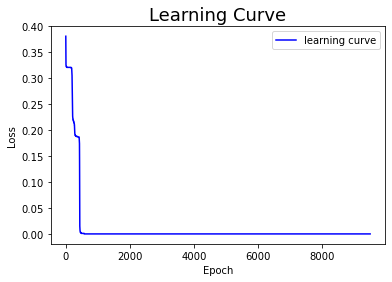

In [31]:
seed(1)
X_train, Y_train = generate_XOR_easy()
network = establishNN(2,2,2,1)

l_rate = 4
n_epoch = 9500
n_outputs = 1
trainNetwork(network, X_train, Y_train, l_rate, n_epoch, n_outputs, havelearningCurve=True)

Predict:0, [0. 0.]
Predict:1, [0. 1.]
Predict:2, [0.1 0.1]
Predict:3, [0.1 0.9]
Predict:4, [0.2 0.2]
Predict:5, [0.2 0.8]
Predict:6, [0.3 0.3]
Predict:7, [0.3 0.7]
Predict:8, [0.4 0.4]
Predict:9, [0.4 0.6]
Predict:10, [0.5 0.5]
Predict:11, [0.6 0.6]
Predict:12, [0.6 0.4]
Predict:13, [0.7 0.7]
Predict:14, [0.7 0.3]
Predict:15, [0.8 0.8]
Predict:16, [0.8 0.2]
Predict:17, [0.9 0.9]
Predict:18, [0.9 0.1]
Predict:19, [1. 1.]
Predict:20, [1. 0.]
[0.002307358251802671, 0.9976778031035066, 0.002325049613053592, 0.997674490120948, 0.0023419092960564134, 0.9976660794191708, 0.002357816158932657, 0.9975827201427059, 0.0023726875519786144, 0.9951556429984734, 0.00238647904854502, 0.0023991816818682943, 0.9961526221389819, 0.002410817367651476, 0.9979617944782173, 0.0024214332576447764, 0.9980471663415394, 0.002431095714364391, 0.9980663048031394, 0.002439884464318189, 0.9980786364660407]
print Red 0.002307358251802671
print Blue 0.9976778031035066
print Red 0.002325049613053592
print Blue 0.997674

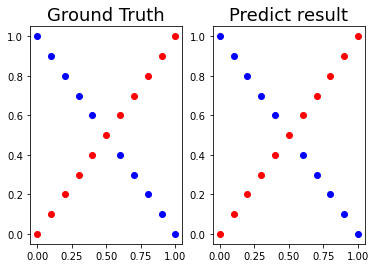

In [32]:
Y_predict = predictModel(network, X_train)
print(Y_predict)
show_result(X_train, Y_train, Y_predict)

----Network Description----
total 3 layers
two hidden layer
one output layer
-Layer 1-
2 neurons
neuron0:
weight:[-0.7312715117751976, 0.6948674738744653]
bias:0.5275492379532281
neuron1:
weight:[-0.4898619485211566, -0.009129825816118098]
bias:-0.10101787042252375
-Layer 2-
2 neurons
neuron0:
weight:[0.3031859454455259, 0.5774467022710263]
bias:-0.8122808264515302
neuron1:
weight:[-0.9433050469559874, 0.6715302078397394]
bias:-0.13446586418989326
-Layer 3-
1 neurons
neuron0:
weight:[0.524560164915884, -0.9957878932977786]
bias:-0.10922561189039715
---------------------------
==epoch=0, lrate=0.200, error=0.244==
==epoch=1, lrate=0.200, error=0.234==
==epoch=2, lrate=0.200, error=0.198==
==epoch=3, lrate=0.200, error=0.120==
==epoch=4, lrate=0.200, error=0.067==
==epoch=5, lrate=0.200, error=0.045==
==epoch=6, lrate=0.200, error=0.035==
==epoch=7, lrate=0.200, error=0.030==
==epoch=8, lrate=0.200, error=0.026==
==epoch=9, lrate=0.200, error=0.024==
==epoch=10, lrate=0.200, error=0.022=

==epoch=196, lrate=0.200, error=0.005==
==epoch=197, lrate=0.200, error=0.005==
==epoch=198, lrate=0.200, error=0.005==
==epoch=199, lrate=0.200, error=0.005==
==epoch=200, lrate=0.200, error=0.005==
==epoch=201, lrate=0.200, error=0.005==
==epoch=202, lrate=0.200, error=0.005==
==epoch=203, lrate=0.200, error=0.005==
==epoch=204, lrate=0.200, error=0.005==
==epoch=205, lrate=0.200, error=0.005==
==epoch=206, lrate=0.200, error=0.005==
==epoch=207, lrate=0.200, error=0.005==
==epoch=208, lrate=0.200, error=0.005==
==epoch=209, lrate=0.200, error=0.005==
==epoch=210, lrate=0.200, error=0.005==
==epoch=211, lrate=0.200, error=0.005==
==epoch=212, lrate=0.200, error=0.005==
==epoch=213, lrate=0.200, error=0.005==
==epoch=214, lrate=0.200, error=0.005==
==epoch=215, lrate=0.200, error=0.005==
==epoch=216, lrate=0.200, error=0.005==
==epoch=217, lrate=0.200, error=0.005==
==epoch=218, lrate=0.200, error=0.005==
==epoch=219, lrate=0.200, error=0.005==
==epoch=220, lrate=0.200, error=0.005==


==epoch=405, lrate=0.200, error=0.003==
==epoch=406, lrate=0.200, error=0.003==
==epoch=407, lrate=0.200, error=0.003==
==epoch=408, lrate=0.200, error=0.003==
==epoch=409, lrate=0.200, error=0.003==
==epoch=410, lrate=0.200, error=0.003==
==epoch=411, lrate=0.200, error=0.003==
==epoch=412, lrate=0.200, error=0.003==
==epoch=413, lrate=0.200, error=0.003==
==epoch=414, lrate=0.200, error=0.003==
==epoch=415, lrate=0.200, error=0.003==
==epoch=416, lrate=0.200, error=0.003==
==epoch=417, lrate=0.200, error=0.003==
==epoch=418, lrate=0.200, error=0.003==
==epoch=419, lrate=0.200, error=0.003==
==epoch=420, lrate=0.200, error=0.003==
==epoch=421, lrate=0.200, error=0.003==
==epoch=422, lrate=0.200, error=0.003==
==epoch=423, lrate=0.200, error=0.003==
==epoch=424, lrate=0.200, error=0.003==
==epoch=425, lrate=0.200, error=0.003==
==epoch=426, lrate=0.200, error=0.003==
==epoch=427, lrate=0.200, error=0.003==
==epoch=428, lrate=0.200, error=0.003==
==epoch=429, lrate=0.200, error=0.003==


==epoch=616, lrate=0.200, error=0.004==
==epoch=617, lrate=0.200, error=0.004==
==epoch=618, lrate=0.200, error=0.004==
==epoch=619, lrate=0.200, error=0.004==
==epoch=620, lrate=0.200, error=0.004==
==epoch=621, lrate=0.200, error=0.004==
==epoch=622, lrate=0.200, error=0.004==
==epoch=623, lrate=0.200, error=0.004==
==epoch=624, lrate=0.200, error=0.004==
==epoch=625, lrate=0.200, error=0.004==
==epoch=626, lrate=0.200, error=0.004==
==epoch=627, lrate=0.200, error=0.004==
==epoch=628, lrate=0.200, error=0.004==
==epoch=629, lrate=0.200, error=0.004==
==epoch=630, lrate=0.200, error=0.004==
==epoch=631, lrate=0.200, error=0.004==
==epoch=632, lrate=0.200, error=0.004==
==epoch=633, lrate=0.200, error=0.004==
==epoch=634, lrate=0.200, error=0.004==
==epoch=635, lrate=0.200, error=0.004==
==epoch=636, lrate=0.200, error=0.004==
==epoch=637, lrate=0.200, error=0.004==
==epoch=638, lrate=0.200, error=0.004==
==epoch=639, lrate=0.200, error=0.004==
==epoch=640, lrate=0.200, error=0.004==


==epoch=824, lrate=0.200, error=0.003==
==epoch=825, lrate=0.200, error=0.003==
==epoch=826, lrate=0.200, error=0.003==
==epoch=827, lrate=0.200, error=0.003==
==epoch=828, lrate=0.200, error=0.003==
==epoch=829, lrate=0.200, error=0.003==
==epoch=830, lrate=0.200, error=0.003==
==epoch=831, lrate=0.200, error=0.003==
==epoch=832, lrate=0.200, error=0.003==
==epoch=833, lrate=0.200, error=0.003==
==epoch=834, lrate=0.200, error=0.003==
==epoch=835, lrate=0.200, error=0.003==
==epoch=836, lrate=0.200, error=0.003==
==epoch=837, lrate=0.200, error=0.003==
==epoch=838, lrate=0.200, error=0.003==
==epoch=839, lrate=0.200, error=0.003==
==epoch=840, lrate=0.200, error=0.003==
==epoch=841, lrate=0.200, error=0.003==
==epoch=842, lrate=0.200, error=0.003==
==epoch=843, lrate=0.200, error=0.003==
==epoch=844, lrate=0.200, error=0.003==
==epoch=845, lrate=0.200, error=0.003==
==epoch=846, lrate=0.200, error=0.003==
==epoch=847, lrate=0.200, error=0.003==
==epoch=848, lrate=0.200, error=0.003==


==epoch=1035, lrate=0.200, error=0.003==
==epoch=1036, lrate=0.200, error=0.003==
==epoch=1037, lrate=0.200, error=0.003==
==epoch=1038, lrate=0.200, error=0.003==
==epoch=1039, lrate=0.200, error=0.003==
==epoch=1040, lrate=0.200, error=0.003==
==epoch=1041, lrate=0.200, error=0.003==
==epoch=1042, lrate=0.200, error=0.003==
==epoch=1043, lrate=0.200, error=0.003==
==epoch=1044, lrate=0.200, error=0.003==
==epoch=1045, lrate=0.200, error=0.003==
==epoch=1046, lrate=0.200, error=0.003==
==epoch=1047, lrate=0.200, error=0.003==
==epoch=1048, lrate=0.200, error=0.003==
==epoch=1049, lrate=0.200, error=0.003==
==epoch=1050, lrate=0.200, error=0.003==
==epoch=1051, lrate=0.200, error=0.003==
==epoch=1052, lrate=0.200, error=0.003==
==epoch=1053, lrate=0.200, error=0.003==
==epoch=1054, lrate=0.200, error=0.003==
==epoch=1055, lrate=0.200, error=0.003==
==epoch=1056, lrate=0.200, error=0.003==
==epoch=1057, lrate=0.200, error=0.003==
==epoch=1058, lrate=0.200, error=0.003==
==epoch=1059, lr

==epoch=1241, lrate=0.200, error=0.003==
==epoch=1242, lrate=0.200, error=0.003==
==epoch=1243, lrate=0.200, error=0.003==
==epoch=1244, lrate=0.200, error=0.003==
==epoch=1245, lrate=0.200, error=0.003==
==epoch=1246, lrate=0.200, error=0.003==
==epoch=1247, lrate=0.200, error=0.003==
==epoch=1248, lrate=0.200, error=0.003==
==epoch=1249, lrate=0.200, error=0.003==
==epoch=1250, lrate=0.200, error=0.003==
==epoch=1251, lrate=0.200, error=0.003==
==epoch=1252, lrate=0.200, error=0.003==
==epoch=1253, lrate=0.200, error=0.003==
==epoch=1254, lrate=0.200, error=0.003==
==epoch=1255, lrate=0.200, error=0.003==
==epoch=1256, lrate=0.200, error=0.003==
==epoch=1257, lrate=0.200, error=0.003==
==epoch=1258, lrate=0.200, error=0.003==
==epoch=1259, lrate=0.200, error=0.003==
==epoch=1260, lrate=0.200, error=0.003==
==epoch=1261, lrate=0.200, error=0.003==
==epoch=1262, lrate=0.200, error=0.003==
==epoch=1263, lrate=0.200, error=0.003==
==epoch=1264, lrate=0.200, error=0.003==
==epoch=1265, lr

==epoch=1445, lrate=0.200, error=0.003==
==epoch=1446, lrate=0.200, error=0.003==
==epoch=1447, lrate=0.200, error=0.003==
==epoch=1448, lrate=0.200, error=0.003==
==epoch=1449, lrate=0.200, error=0.003==
==epoch=1450, lrate=0.200, error=0.003==
==epoch=1451, lrate=0.200, error=0.003==
==epoch=1452, lrate=0.200, error=0.003==
==epoch=1453, lrate=0.200, error=0.003==
==epoch=1454, lrate=0.200, error=0.003==
==epoch=1455, lrate=0.200, error=0.003==
==epoch=1456, lrate=0.200, error=0.003==
==epoch=1457, lrate=0.200, error=0.003==
==epoch=1458, lrate=0.200, error=0.003==
==epoch=1459, lrate=0.200, error=0.003==
==epoch=1460, lrate=0.200, error=0.003==
==epoch=1461, lrate=0.200, error=0.003==
==epoch=1462, lrate=0.200, error=0.003==
==epoch=1463, lrate=0.200, error=0.003==
==epoch=1464, lrate=0.200, error=0.003==
==epoch=1465, lrate=0.200, error=0.003==
==epoch=1466, lrate=0.200, error=0.003==
==epoch=1467, lrate=0.200, error=0.003==
==epoch=1468, lrate=0.200, error=0.003==
==epoch=1469, lr

==epoch=1650, lrate=0.200, error=0.003==
==epoch=1651, lrate=0.200, error=0.003==
==epoch=1652, lrate=0.200, error=0.003==
==epoch=1653, lrate=0.200, error=0.003==
==epoch=1654, lrate=0.200, error=0.003==
==epoch=1655, lrate=0.200, error=0.003==
==epoch=1656, lrate=0.200, error=0.003==
==epoch=1657, lrate=0.200, error=0.003==
==epoch=1658, lrate=0.200, error=0.003==
==epoch=1659, lrate=0.200, error=0.003==
==epoch=1660, lrate=0.200, error=0.003==
==epoch=1661, lrate=0.200, error=0.003==
==epoch=1662, lrate=0.200, error=0.003==
==epoch=1663, lrate=0.200, error=0.003==
==epoch=1664, lrate=0.200, error=0.003==
==epoch=1665, lrate=0.200, error=0.003==
==epoch=1666, lrate=0.200, error=0.003==
==epoch=1667, lrate=0.200, error=0.003==
==epoch=1668, lrate=0.200, error=0.003==
==epoch=1669, lrate=0.200, error=0.003==
==epoch=1670, lrate=0.200, error=0.003==
==epoch=1671, lrate=0.200, error=0.003==
==epoch=1672, lrate=0.200, error=0.003==
==epoch=1673, lrate=0.200, error=0.003==
==epoch=1674, lr

==epoch=1855, lrate=0.200, error=0.002==
==epoch=1856, lrate=0.200, error=0.002==
==epoch=1857, lrate=0.200, error=0.002==
==epoch=1858, lrate=0.200, error=0.002==
==epoch=1859, lrate=0.200, error=0.002==
==epoch=1860, lrate=0.200, error=0.002==
==epoch=1861, lrate=0.200, error=0.003==
==epoch=1862, lrate=0.200, error=0.002==
==epoch=1863, lrate=0.200, error=0.002==
==epoch=1864, lrate=0.200, error=0.002==
==epoch=1865, lrate=0.200, error=0.002==
==epoch=1866, lrate=0.200, error=0.002==
==epoch=1867, lrate=0.200, error=0.002==
==epoch=1868, lrate=0.200, error=0.003==
==epoch=1869, lrate=0.200, error=0.003==
==epoch=1870, lrate=0.200, error=0.002==
==epoch=1871, lrate=0.200, error=0.003==
==epoch=1872, lrate=0.200, error=0.003==
==epoch=1873, lrate=0.200, error=0.003==
==epoch=1874, lrate=0.200, error=0.003==
==epoch=1875, lrate=0.200, error=0.003==
==epoch=1876, lrate=0.200, error=0.003==
==epoch=1877, lrate=0.200, error=0.003==
==epoch=1878, lrate=0.200, error=0.003==
==epoch=1879, lr

==epoch=2057, lrate=0.200, error=0.002==
==epoch=2058, lrate=0.200, error=0.003==
==epoch=2059, lrate=0.200, error=0.003==
==epoch=2060, lrate=0.200, error=0.002==
==epoch=2061, lrate=0.200, error=0.002==
==epoch=2062, lrate=0.200, error=0.003==
==epoch=2063, lrate=0.200, error=0.002==
==epoch=2064, lrate=0.200, error=0.003==
==epoch=2065, lrate=0.200, error=0.002==
==epoch=2066, lrate=0.200, error=0.003==
==epoch=2067, lrate=0.200, error=0.002==
==epoch=2068, lrate=0.200, error=0.003==
==epoch=2069, lrate=0.200, error=0.003==
==epoch=2070, lrate=0.200, error=0.002==
==epoch=2071, lrate=0.200, error=0.002==
==epoch=2072, lrate=0.200, error=0.002==
==epoch=2073, lrate=0.200, error=0.002==
==epoch=2074, lrate=0.200, error=0.003==
==epoch=2075, lrate=0.200, error=0.002==
==epoch=2076, lrate=0.200, error=0.003==
==epoch=2077, lrate=0.200, error=0.002==
==epoch=2078, lrate=0.200, error=0.003==
==epoch=2079, lrate=0.200, error=0.002==
==epoch=2080, lrate=0.200, error=0.002==
==epoch=2081, lr

==epoch=2263, lrate=0.200, error=0.003==
==epoch=2264, lrate=0.200, error=0.003==
==epoch=2265, lrate=0.200, error=0.002==
==epoch=2266, lrate=0.200, error=0.003==
==epoch=2267, lrate=0.200, error=0.002==
==epoch=2268, lrate=0.200, error=0.002==
==epoch=2269, lrate=0.200, error=0.003==
==epoch=2270, lrate=0.200, error=0.002==
==epoch=2271, lrate=0.200, error=0.003==
==epoch=2272, lrate=0.200, error=0.003==
==epoch=2273, lrate=0.200, error=0.003==
==epoch=2274, lrate=0.200, error=0.002==
==epoch=2275, lrate=0.200, error=0.003==
==epoch=2276, lrate=0.200, error=0.003==
==epoch=2277, lrate=0.200, error=0.003==
==epoch=2278, lrate=0.200, error=0.003==
==epoch=2279, lrate=0.200, error=0.002==
==epoch=2280, lrate=0.200, error=0.003==
==epoch=2281, lrate=0.200, error=0.003==
==epoch=2282, lrate=0.200, error=0.002==
==epoch=2283, lrate=0.200, error=0.003==
==epoch=2284, lrate=0.200, error=0.002==
==epoch=2285, lrate=0.200, error=0.003==
==epoch=2286, lrate=0.200, error=0.002==
==epoch=2287, lr

==epoch=2463, lrate=0.200, error=0.002==
==epoch=2464, lrate=0.200, error=0.003==
==epoch=2465, lrate=0.200, error=0.003==
==epoch=2466, lrate=0.200, error=0.003==
==epoch=2467, lrate=0.200, error=0.003==
==epoch=2468, lrate=0.200, error=0.003==
==epoch=2469, lrate=0.200, error=0.003==
==epoch=2470, lrate=0.200, error=0.003==
==epoch=2471, lrate=0.200, error=0.003==
==epoch=2472, lrate=0.200, error=0.003==
==epoch=2473, lrate=0.200, error=0.003==
==epoch=2474, lrate=0.200, error=0.003==
==epoch=2475, lrate=0.200, error=0.003==
==epoch=2476, lrate=0.200, error=0.003==
==epoch=2477, lrate=0.200, error=0.003==
==epoch=2478, lrate=0.200, error=0.003==
==epoch=2479, lrate=0.200, error=0.003==
==epoch=2480, lrate=0.200, error=0.003==
==epoch=2481, lrate=0.200, error=0.003==
==epoch=2482, lrate=0.200, error=0.003==
==epoch=2483, lrate=0.200, error=0.002==
==epoch=2484, lrate=0.200, error=0.002==
==epoch=2485, lrate=0.200, error=0.002==
==epoch=2486, lrate=0.200, error=0.002==
==epoch=2487, lr

==epoch=2665, lrate=0.200, error=0.002==
==epoch=2666, lrate=0.200, error=0.002==
==epoch=2667, lrate=0.200, error=0.002==
==epoch=2668, lrate=0.200, error=0.002==
==epoch=2669, lrate=0.200, error=0.002==
==epoch=2670, lrate=0.200, error=0.003==
==epoch=2671, lrate=0.200, error=0.002==
==epoch=2672, lrate=0.200, error=0.002==
==epoch=2673, lrate=0.200, error=0.002==
==epoch=2674, lrate=0.200, error=0.002==
==epoch=2675, lrate=0.200, error=0.002==
==epoch=2676, lrate=0.200, error=0.003==
==epoch=2677, lrate=0.200, error=0.002==
==epoch=2678, lrate=0.200, error=0.002==
==epoch=2679, lrate=0.200, error=0.002==
==epoch=2680, lrate=0.200, error=0.003==
==epoch=2681, lrate=0.200, error=0.003==
==epoch=2682, lrate=0.200, error=0.002==
==epoch=2683, lrate=0.200, error=0.002==
==epoch=2684, lrate=0.200, error=0.002==
==epoch=2685, lrate=0.200, error=0.002==
==epoch=2686, lrate=0.200, error=0.003==
==epoch=2687, lrate=0.200, error=0.002==
==epoch=2688, lrate=0.200, error=0.002==
==epoch=2689, lr

==epoch=2870, lrate=0.200, error=0.002==
==epoch=2871, lrate=0.200, error=0.002==
==epoch=2872, lrate=0.200, error=0.002==
==epoch=2873, lrate=0.200, error=0.002==
==epoch=2874, lrate=0.200, error=0.002==
==epoch=2875, lrate=0.200, error=0.002==
==epoch=2876, lrate=0.200, error=0.002==
==epoch=2877, lrate=0.200, error=0.002==
==epoch=2878, lrate=0.200, error=0.002==
==epoch=2879, lrate=0.200, error=0.002==
==epoch=2880, lrate=0.200, error=0.002==
==epoch=2881, lrate=0.200, error=0.002==
==epoch=2882, lrate=0.200, error=0.002==
==epoch=2883, lrate=0.200, error=0.002==
==epoch=2884, lrate=0.200, error=0.003==
==epoch=2885, lrate=0.200, error=0.003==
==epoch=2886, lrate=0.200, error=0.003==
==epoch=2887, lrate=0.200, error=0.003==
==epoch=2888, lrate=0.200, error=0.003==
==epoch=2889, lrate=0.200, error=0.003==
==epoch=2890, lrate=0.200, error=0.003==
==epoch=2891, lrate=0.200, error=0.003==
==epoch=2892, lrate=0.200, error=0.003==
==epoch=2893, lrate=0.200, error=0.003==
==epoch=2894, lr

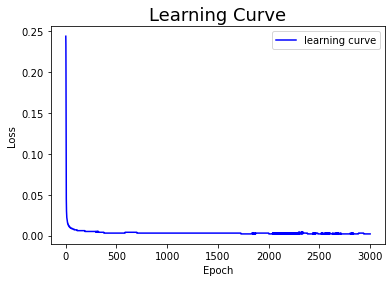

In [39]:
seed(1)
X_train, Y_train = generate_linear(n=900)
network = establishNN(2,2,2,1)

l_rate = 0.2
n_epoch = 3000
n_outputs = 1
trainNetwork(network, X_train, Y_train, l_rate, n_epoch, n_outputs, havelearningCurve=True)

Predict:0, [0.86246216 0.93480817]
Predict:1, [0.72414116 0.27709062]
Predict:2, [0.39116082 0.53103493]
Predict:3, [0.81825428 0.50911961]
Predict:4, [0.43924275 0.98736271]
Predict:5, [0.33877203 0.57677418]
Predict:6, [0.85766014 0.77997809]
Predict:7, [0.26619505 0.3035402 ]
Predict:8, [0.53196773 0.96572641]
Predict:9, [0.41924083 0.16381785]
Predict:10, [0.48646985 0.67759291]
Predict:11, [0.68204801 0.71272213]
Predict:12, [0.48983339 0.08395354]
Predict:13, [0.49246732 0.75756511]
Predict:14, [0.13289255 0.85844427]
Predict:15, [0.04146721 0.90926527]
Predict:16, [0.66355579 0.96771752]
Predict:17, [0.6265712  0.34439603]
Predict:18, [0.80082112 0.92106488]
Predict:19, [0.73842518 0.83060556]
Predict:20, [0.71054643 0.60995821]
Predict:21, [0.48152768 0.24006153]
Predict:22, [0.5496766  0.91190023]
Predict:23, [0.52881798 0.81444873]
Predict:24, [0.98513327 0.43272801]
Predict:25, [0.80540786 0.98888875]
Predict:26, [0.41455979 0.18789703]
Predict:27, [0.30785246 0.68319352]
Pr

print Blue 0.9999470959330625
print Red 0.0009101508850304712
print Blue 0.9999536658953608
print Red 0.0009326303884814907
print Blue 0.9999565833727594
print Blue 0.9999557145184754
print Red 0.0017306669407874745
print Blue 0.9997118493823725
print Blue 0.9999565590520667
print Red 0.0009160690447569571
print Blue 0.9999557383093807
print Blue 0.9993258132458079
print Red 0.0009087276989122119
print Blue 0.9999562741017699
print Blue 0.9999565922918305
print Blue 0.9999565978832157
print Blue 0.9999564963169422
print Red 0.0009227484166203574
print Blue 0.9999553834593826
print Blue 0.9999529395090637
print Red 0.001161755249081142
print Red 0.0009209461832949465
print Blue 0.9999565154276673
print Blue 0.9999563799128746
print Red 0.000909646685211106
print Blue 0.9999563104435875
print Red 0.0009196323263139371
print Blue 0.9999564078166411
print Blue 0.999951409034833
print Blue 0.99995652588987
print Blue 0.9999565870468596
print Blue 0.9999548220530295
print Blue 0.999955258328

print Red 0.0014811294903829925
print Red 0.0009077284960027795
print Blue 0.999820647252712
print Red 0.0009085509728061007
print Blue 0.9999545376989903
print Red 0.0014142174671373142
print Red 0.0009189460441519005
print Red 0.0009131709982561231
print Blue 0.9999562757716212
print Blue 0.991112376510841
print Red 0.0010802885539691796
print Red 0.0010193661076391808
print Blue 0.9999565556791956
print Red 0.008189582060084404
print Red 0.000914306941178408
print Red 0.01958638887163188
print Red 0.000906554133361038
print Blue 0.9999551006212398
print Red 0.0009127751488950217
print Blue 0.9999563175545461
print Red 0.0009389177098760707
print Red 0.0010394215560943828
print Blue 0.9999565684460664
print Blue 0.9999519151160703
print Red 0.0013521013717751485
print Blue 0.9999106713300796
print Blue 0.9999554542426574
print Red 0.0022889669634832675
print Blue 0.9999565952983765
print Red 0.0009157528999890075
print Red 0.0011066765281212939
print Blue 0.9999560721010201
print Red

print Blue 0.9999556906444983
print Red 0.0009075725979099678
print Blue 0.9999565441349965
print Blue 0.9999502623658991
print Blue 0.9999565165961394
print Blue 0.999954717396891
print Blue 0.9999555646458758
print Red 0.0009086848077711848
print Red 0.0009077654668986518
print Red 0.0009615923889744997
print Red 0.6228297068067037
print Red 0.0009227835807666757
print Blue 0.9999549369703439
print Red 0.0010721722451391112
print Blue 0.9999533901872368
print Red 0.0019026886895402706
print Red 0.0009221590808513517
print Red 0.0009574999151672372
print Blue 0.9999564794365884
print Red 0.0009665113241478667
print Red 0.0009083436714282274
print Red 0.000906439365429682
print Red 0.0010611055067871822
print Red 0.0009074969043387184
print Red 0.0009135940609957986
print Blue 0.9999521728926969
print Red 0.001278278320541924
print Red 0.0009068647944668144
print Blue 0.9999556640491504
print Blue 0.9999551759751836
print Red 0.0009475754348253238
print Red 0.003125976957540522
print R

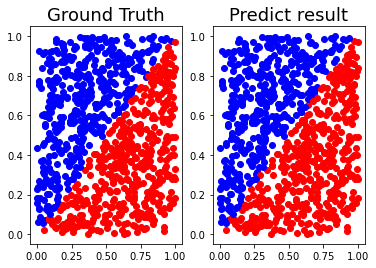

In [40]:
Y_predict = predictModel(network, X_train)
show_result(X_train, Y_train, Y_predict)

In [ ]:
network

In [ ]:
X_train

In [ ]:
Y_train

In [ ]:
uniform(-1,1)

In [ ]:
a = [1,2]
b = a.copy()
a.clear()
b[0]= 30
b

In [ ]:
print(round(0.000234, 4))